# XAS Workflow Task 2

This notebook contains the second task of the XAS processing workflow. 

The break up of the task consist of the following steps 

|Task                            | Input                                         | Output
|-------------                   |-------------                                  |-----  
| Curve fitting||
| 1. Import data                |File: FeS2_larch.prj                              |
| 2. Import Crystal data        |File: FeS2.inp                                 |
| 3. Calculate Paths(Atoms+FEFF)||
| 4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 5. Run Fit                    |                                               |
| 6. Save project               ||
| 7. Verify fit results         ||
| 7.1 If not OK revise parameners and refit (go to 2.4)||
| 7.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


In [1]:
# managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup

project_name = 'FeS2_larch.prj'


fes2_prj = read_athena(project_name)

group_keys = list(fes2_prj._athena_groups.keys())

group_names = {}

for group_key in group_keys:
    group_names[group_key] = group_key

{'__name__': '0x1210be30', 'algorithm': 'autobk', 'cl': 0.0, 'clamp1': 0.0, 'clamp2': 24.0, 'delta_eshift': 0.0, 'dk': 1.0, 'e0': 7117.0, 'e0_fraction': 0.5, 'eshift': 0.0, 'fitted_step': 0.7269848206913032, 'fixstep': 0.0, 'flatten': 1.0, 'former_e0': 0.0, 'funnorm': 0.0, 'int': 7.0, 'kw': 1.0, 'kwindow': 'hanning', 'nc0': 0.0, 'nc1': 0.0, 'nc2': 0.0, 'nc3': 0.0, 'nclamp': 5.0, 'nnorm': 2.0, 'nor1': 285.0, 'nor2': 850.0, 'pre1': -117.0, 'pre2': -30.0, 'rbkg': 1.0, 'slope': 0.0, 'spl1': 0.0, 'spl1e': 0.0, 'spl2': 14.9562, 'spl2e': 852.247, 'stan': 'None', 'step': 0.7269848206913032, 'tie_e0': 0.0, 'z': 'Fe'}
-117.0


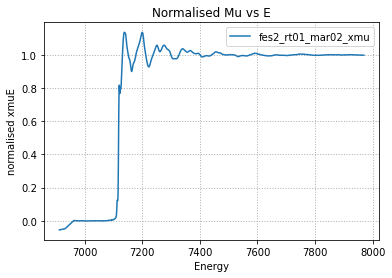

In [10]:
# required larch modules
# calculate pre-edge and post edge for normalisation
from larch.xafs import pre_edge
# perform background removal
from larch.xafs import autobk
# calculate fourier transform
from larch.xafs import xftf

%matplotlib inline
import matplotlib.pyplot as plt

 #######################################################
# |         Athena recalculates everything so we      | #
# |      need to create a function that calculates    | #
# V               all for each new group              V #
 #######################################################

def calc_with_defaults(xafs_group):
    # calculate mu and normalise with background extraction
    # should let the user specify the colums for i0, it, mu, iR. 
    if not hasattr(xafs_group, 'mu'):
        xafs_group = get_mu(xafs_group)
    # calculate pre-edge and post edge and add them to group
    # need to read parameters for pre-edge before background calculation with  
    # defaul values undo the work of previous step (setting pre-edge limits).
    pre_edge(xafs_group, pre1=xafs_group.bkg_params.pre1, pre2=xafs_group.bkg_params.pre2)
    #pre_edge(xafs_group)
    # perform background removal
    autobk(xafs_group) # using defaults so no additional parameters are passed
    # calculate fourier transform
    xftf(xafs_group)#, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
    return xafs_group


 #######################################################
# |       The code for plotting Nmu vs E repeats      | #
# |   so it is useful to have a plotting function     | #
# V            to reduce duplicated code              V #
 #######################################################
# plot mu vs flat normalised mu for selected groups
def plot_NxmuE_E_athena_prj(athena_project, group_keys, group_names,
                            title = "Normalised Mu vs E", xlimits = None,
                            ylimits = None):    
    # plot mu vs flat normalised mu for selected groups
    for group_key in group_keys:
        gr_0 = extract_athenagroup(athena_project._athena_groups[group_key])
        # recalculate normalisation
        calc_with_defaults(gr_0)
        plt.plot(gr_0.energy, gr_0.flat, label=group_names[group_key])

    # set plot format
    plt.xlabel("Energy")
    plt.ylabel("normalised xmuE" )
    plt.title(title)
    plt.grid(linestyle=':', linewidth=1) #show and format grid
    if xlimits != None:
        plt.xlim(xlimits[0],xlimits[1])
    if ylimits != None:
        plt.ylim(ylimits[0],ylimits[1])
    plt.legend()
    return plt

# plot normalised mu on energy
# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(fes2_prj, group_keys, group_names)
plt.show()


In [3]:
# larch does not include a means for running atoms
# need to run atoms to get input for feff and then
# calculate paths

# currently the fastest option is to run Artemis to
# obtain the input (.inp) file for feff from a '.cif'
# or '.inp' file

# get subprocess to run perl script
import subprocess

# get the input file
var = "FeS2.inp"

retcode = subprocess.call(["perl", "feff_inp.pl", var])
if retcode == 0:
    print("Passed!")
else:
    print("Failed!")

# run feff and get the paths
from larch.xafs.feffrunner import feff6l
#feff6l(folder='.', feffinp='feff.inp', verbose=True)
feff6l(folder = './fes2_feff',feffinp='fes2_feff.inp' )

Passed!
 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit       9
 : Searching for paths...
 : Rmax  6.0000  keep and heap limits   0.0000000   0.0000000
 : Preparing neigh

<External Feff Group: ./fes2_feff\fes2_feff.inp>

In [4]:
# set parameters 

In [5]:
# run fit

In [3]:
## examples/feffit/doc_feffit1.lar
## https://xraypy.github.io/xraylarch/xafs/feffit.html#example-1-simple-fit-with-1-path
# import needed for python:
import larch
from larch.io import read_ascii
from larch.fitting import param, guess, param_group
from larch.xafs import autobk, feffpath, feffit_transform, feffit_dataset, feffit, feffit_report
from larch.wxlib.xafsplots import plot_chifit

import lmfit
# read data
cu_data  = read_ascii('../xafsdata/cu_metal_rt.xdi')
autobk(cu_data.energy, cu_data.mutrans, group=cu_data, rbkg=1.0, kw=2)

# define fitting parameter group
#pars = larch.fitting.ParameterGroup
#setattr(pars, 'amp', param(1.0, vary=True))
#setattr(pars, 'del_e0', param(0.0, vary=True))
#setattr(pars, 'sig2', param(0.0, vary=True))
#setattr(pars, 'del_r', guess(0.0, vary=True))

pars = larch.fitting.ParameterGroup()
lmg_pars = lmfit.parameter.Parameters()
pars.__params__ = lmg_pars
setattr(pars, 'amp', param(1.0, vary=True))
pars.__params__.add('amp', value = 1.0, vary=True) 
setattr(pars, 'del_e0', param(0.0, vary=True))
pars.__params__.add('del_e0', value = 0.0, vary=True) 
setattr(pars, 'sig2', param(0.0, vary=True))
pars.__params__.add('sig2', value = 0.0, vary=True) 
setattr(pars, 'del_r', guess(0.0, vary=True))
pars.__params__.add('del_r', value = 0.0) 


# define a Feff Path, give expressions for Path Parameters
path1 = feffpath('feffcu01.dat',
                 s02    = 'amp',
                 e0     = 'del_e0',
                 sigma2 = 'sig2',
                 deltar = 'del_r')

# set tranform / fit ranges
trans = feffit_transform(kmin=3, kmax=17, kw=2, dk=4, window='kaiser', rmin=1.4, rmax=3.0)

# define dataset to include data, pathlist, transform
dset = feffit_dataset(data=cu_data, pathlist=[path1], transform=trans)
dsets = list()
dsets.append(dset)
# perform fit!
out = feffit(pars, dsets)
print(feffit_report(out))
 
try:
    fout = open('doc_feffit1.out', 'w')
    fout.write("%s\n" % feffit_report(out))
    fout.close()
except:
    print('could not write doc_feffit1.out')
#endtry
# 
plot_chifit(dset)

## end examples/feffit/doc_feffit1.lar

AttributeError: 'NoneType' object has no attribute 'symtable'

In [4]:
vars(pars)

mappingproxy({'__module__': 'larch.fitting',
              '__doc__': '\n    Group for Fitting Parameters\n    ',
              '__init__': <function larch.fitting.ParameterGroup.__init__(self, name=None, _larch=None, **kws)>,
              '__repr__': <function larch.fitting.ParameterGroup.__repr__(self)>,
              '__setattr__': <function larch.fitting.ParameterGroup.__setattr__(self, name, val)>,
              '_ParameterGroup__add': <function larch.fitting.ParameterGroup.__add(self, name, value=None, vary=True, min=-inf, max=inf, expr=None, stderr=None, correl=None, brute_step=None)>,
              '__params__': Parameters([('amp',
                           <Parameter 'amp', value=1.0, bounds=[-inf:inf]>),
                          ('del_e0',
                           <Parameter 'del_e0', value=0.0, bounds=[-inf:inf]>),
                          ('sig2',
                           <Parameter 'sig2', value=0.0, bounds=[-inf:inf]>),
                          ('del_r',
        

In [172]:
vars(path1)

{'__name__': 'FeffPath: feffcu01.dat',
 '_larch': None,
 'filename': 'feffcu01.dat',
 'params': None,
 'label': 'pfh2ced6i',
 'spline_coefs': {'pha': <scipy.interpolate.fitpack2.InterpolatedUnivariateSpline at 0x11fc3b10>,
  'amp': <scipy.interpolate.fitpack2.InterpolatedUnivariateSpline at 0x11fc34b0>,
  'rep': <scipy.interpolate.fitpack2.InterpolatedUnivariateSpline at 0x11fc3c50>,
  'lam': <scipy.interpolate.fitpack2.InterpolatedUnivariateSpline at 0x11fc35b0>},
 '_feffdat': <Feff.dat File Group: feffcu01.dat>,
 'geom': [('Cu', 29, 0, 63.546, 0.0, 0.0, 0.0),
  ('Cu', 29, 1, 63.546, 0.0, -1.8016, 1.8016)],
 'degen': 12.0,
 's02': 'amp',
 'e0': 'del_e0',
 'ei': 0.0,
 'deltar': 'del_r',
 'sigma2': 'sig2',
 'third': 0.0,
 'fourth': 0.0,
 'k': None,
 'chi': None}

In [173]:
vars(trans)

{'__name__': '0x11fc30f0',
 'kw': 2,
 'kmin': 3,
 'kmax': 17,
 'kweight': 2,
 'dk': 4,
 'dk2': None,
 'window': 'kaiser',
 'rmin': 1.4,
 'rmax': 3.0,
 'dr': 0,
 'dr2': 0,
 'rwindow': 'hanning',
 '_TransformGroup__nfft': 2048,
 '_TransformGroup__kstep': 0.05,
 'nfft': 2048,
 'kstep': 0.05,
 'rstep': 0.030679615757712823,
 'fitspace': 'r',
 'wavelet_mask': None,
 '_cauchymask': None,
 '_larch': None,
 'kwin': array([0., 0., 0., ..., 0., 0., 0.]),
 'rwin': None,
 'k_': array([0.0000e+00, 5.0000e-02, 1.0000e-01, ..., 1.0225e+02, 1.0230e+02,
        1.0235e+02]),
 'r_': array([0.00000000e+00, 3.06796158e-02, 6.13592315e-02, ...,
        6.27398142e+01, 6.27704938e+01, 6.28011735e+01])}

In [174]:
vars(dset)

{'_larch': None,
 '__name__': '0x11fc3df0',
 'pathlist': [<FeffPath Group feffcu01.dat>],
 'data': <Group ascii_file ../xafsdata/cu_metal_rt.xdi>,
 'transform': <FeffitTransform Group: 0x11fc30f0>,
 'model': <Group 0x11fc39d0>,
 '_FeffitDataSet__chi': array([ 7.52042530e-01,  6.83561606e-01,  6.23386214e-01,  5.70518167e-01,
         5.23959279e-01,  4.82711362e-01,  4.45776227e-01,  4.12155689e-01,
         3.80851559e-01,  3.50865650e-01,  3.21199775e-01,  2.90890576e-01,
         2.59274162e-01,  2.25840524e-01,  1.90117111e-01,  1.51676311e-01,
         1.10175034e-01,  6.56677652e-02,  2.05574007e-02, -2.24701811e-02,
        -6.18109161e-02, -9.34889087e-02, -1.16074646e-01, -1.29702237e-01,
        -1.35220985e-01, -1.42646883e-01, -1.49162073e-01, -1.54434171e-01,
        -1.55461633e-01, -1.52846248e-01, -1.40534759e-01, -1.20336398e-01,
        -9.05911799e-02, -5.55770211e-02, -9.47184808e-03,  3.29915040e-02,
         7.71346441e-02,  1.15226862e-01,  1.38228219e-01,  1.403

In [114]:
out = feffit(pars, dset)

AttributeError: 'NoneType' object has no attribute 'symtable'

In [121]:
pg = ParameterGroup()

In [77]:
pg = param_group(amp = param(1.0, vary=True),
                 del_e0 = param(0.0, vary=True),
                 sig2   = param(0.0, vary=True),
                 del_r  = param(0.0, vary=True))

AttributeError: 'NoneType' object has no attribute 'add'

In [41]:
amp = param(1.0, vary=True)
del_e0 = param(0.0, vary=True)
sig2   = param(0.0, vary=True)
del_r  = guess(0.0, vary=True)

In [122]:
param_group(amp, del_e0)

TypeError: param_group() takes from 0 to 1 positional arguments but 2 were given

In [13]:
import larch
pars = ParameterGroup
setattr(pars, 'amp', param(1.0, vary=True))
setattr(pars, 'del_e0', param(0.0, vary=True))
setattr(pars, 'sig2', param(0.0, vary=True))
setattr(pars, 'del_r', guess(0.0, vary=True))
vars(pars)

NameError: name 'ParameterGroup' is not defined

In [19]:
pars = larch.fitting.ParameterGroup
pars._ParameterGroup__add(pars, name='amp', value = 1.0, vary=True)

TypeError: 'mappingproxy' object does not support item assignment

In [12]:
vars(pars)

{'_larch': None,
 '__params__': None,
 '__name__': '0x5fc6d90',
 '__exprsave__': {}}

In [98]:
gds.amp = param(1.0, vary=True)
setattr(gds,'del_e0',param(0.0, vary=True))

In [136]:
type([('amp', <Parameter 'amp', value=0.9275719344151796 +/- 0.039, bounds=[-inf:inf]>), ('del_e0', <Parameter 'del_e0', value=4.357767809115902 +/- 0.511, bounds=[-inf:inf]>), ('sig2', <Parameter 'sig2', value=0.008669688108863994 +/- 0.000308, bounds=[-inf:inf]>), ('del_r', <Parameter 'del_r', value=-0.006016656955359656 +/- 0.00261, bounds=[-inf:inf]>)]), '__name__': '0x106453f0', '__exprsave__': {}, 'amp': <Parameter 'amp', value=0.9275719344151796 +/- 0.039, bounds=[-inf:inf]>, 'del_e0': <Parameter 'del_e0', value=4.357767809115902 +/- 0.511, bounds=[-inf:inf]>, 'sig2': <Parameter 'sig2', value=0.008669688108863994 +/- 0.000308, bounds=[-inf:inf]>, 'del_r': <Parameter 'del_r', value=-0.006016656955359656 +/- 0.00261, bounds=[-inf:inf]>])
                         '__params__': Parameters([('amp', <Parameter 'amp', value=0.9275719344151796 +/- 0.039, bounds=[-inf:inf]>), ('del_e0', <Parameter 'del_e0', value=4.357767809115902 +/- 0.511, bounds=[-inf:inf]>), ('sig2', <Parameter 'sig2', value=0.008669688108863994 +/- 0.000308, bounds=[-inf:inf]>), ('del_r', <Parameter 'del_r', value=-0.006016656955359656 +/- 0.00261, bounds=[-inf:inf]>)]), '__name__': '0x106453f0', '__exprsave__': {}, 'amp': <Parameter 'amp', value=0.9275719344151796 +/- 0.039, bounds=[-inf:inf]>, 'del_e0': <Parameter 'del_e0', value=4.357767809115902 +/- 0.511, bounds=[-inf:inf]>, 'sig2': <Parameter 'sig2', value=0.008669688108863994 +/- 0.000308, bounds=[-inf:inf]>, 'del_r': <Parameter 'del_r', value=-0.006016656955359656 +/- 0.00261, bounds=[-inf:inf]>

SyntaxError: invalid syntax (<ipython-input-136-dc659c56ed46>, line 1)

In [138]:
import lmfit

In [142]:
print(vars(lmfit.parameter.Parameters))

{'__module__': 'lmfit.parameter', '__doc__': 'An ordered dictionary of all the Parameter objects required to\n    specify a fit model. All minimization and Model fitting routines in\n    lmfit will use exactly one Parameters object, typically given as the\n    first argument to the objective function.\n\n    All keys of a Parameters() instance must be strings and valid Python\n    symbol names, so that the name must match ``[a-z_][a-z0-9_]*`` and\n    cannot be a Python reserved word.\n\n    All values of a Parameters() instance must be Parameter objects.\n\n    A Parameters() instance includes an asteval interpreter used for\n    evaluation of constrained Parameters.\n\n    Parameters() support copying and pickling, and have methods to convert\n    to and from serializations using json strings.\n\n    ', '__init__': <function Parameters.__init__ at 0x0B5474B0>, 'copy': <function Parameters.copy at 0x0B5474F8>, 'update': <function Parameters.update at 0x0B547540>, '__copy__': <function

In [159]:
lmg_pars = lmfit.parameter.Parameters()


In [160]:
lmg_pars.add('amp', param(1.0, vary=True))

In [156]:
lmg_pars

TypeError: unsupported format string passed to Parameter.__format__

Parameters([('alpha', <Parameter 'alpha', value=-inf, bounds=[-inf:inf]>),
            ('amp',
             <Parameter 'amp', value=<Parameter '_tmp_param_', value=1.0, bounds=[-inf:inf]>, bounds=[-inf:inf]>)])

In [161]:
pars.__params__ = lmg_pars

In [162]:
pars.__params__

TypeError: unsupported format string passed to Parameter.__format__

Parameters([('amp',
             <Parameter 'amp', value=<Parameter '_tmp_param_', value=1.0, bounds=[-inf:inf]>, bounds=[-inf:inf]>)])

In [168]:
pars = ParameterGroup()
lmg_pars = lmfit.parameter.Parameters()
pars.__params__ = lmg_pars
setattr(pars, 'amp', param(1.0, vary=True))
pars.__params__.add('amp', value = 1.0, vary=True) 
setattr(pars, 'del_e0', param(0.0, vary=True))
pars.__params__.add('del_e0', value = 0.0, vary=True) 
setattr(pars, 'sig2', param(0.0, vary=True))
pars.__params__.add('sig2', value = 0.0, vary=True) 
setattr(pars, 'del_r', guess(0.0, vary=True))
pars.__params__.add('del_r', value = 0.0) 
vars(pars)

{'_larch': None,
 '__params__': Parameters([('amp',
              <Parameter 'amp', value=1.0, bounds=[-inf:inf]>),
             ('del_e0', <Parameter 'del_e0', value=0.0, bounds=[-inf:inf]>),
             ('sig2', <Parameter 'sig2', value=0.0, bounds=[-inf:inf]>),
             ('del_r', <Parameter 'del_r', value=0.0, bounds=[-inf:inf]>)]),
 '__name__': '0xf1e110',
 '__exprsave__': {},
 'amp': <Parameter 'amp', value=1.0, bounds=[-inf:inf]>,
 'del_e0': <Parameter 'del_e0', value=0.0, bounds=[-inf:inf]>,
 'sig2': <Parameter 'sig2', value=0.0, bounds=[-inf:inf]>,
 'del_r': <Parameter 'del_r', value=0.0, bounds=[-inf:inf]>}